In [1]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd './gdrive/MyDrive/Colab Notebooks/DL-ROMs/brain_damage'

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/brain_damage


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [5]:
# Set device and seed

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(0)

In [6]:
# Domain definition

loop = lambda v: np.concatenate((v, v[[0]]))
brain = np.load("brainshape.npz")
domain = fe.polygon(loop(brain["main"][::9])) - fe.polygon(loop(brain["hole1"][::9])) - fe.polygon(loop(brain["hole2"][::8]))

In [7]:
# Meshes and FEM spaces definition

h_ref = 0.02
mesh_ref = fe.mesh(domain, stepsize=h_ref)
Vh_ref = fe.space(mesh_ref, 'CG', 1)
nh_ref = Vh_ref.dim()

mesh_C = fe.loadmesh("./brain-meshes/brain-mesh30.xml")
h = mesh_C.hmax()
Vh_C = fe.space(mesh_C, 'CG', 1)
# mesh_C = fe.mesh(domain, stepsize=5/2*h)
# Vh_C = fe.space(mesh_C, 'CG', 1)
nh_ref, nh_C = Vh_ref.dim(), Vh_C.dim()

print(nh_ref, nh_C)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00433064 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.170055 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

3378 1490


In [8]:
# Load low-fidelity snapshots for training

# data_train = np.load("snapshots_train_C.npz")
data_train = np.load("snapshots_train_H2C_30.npz")
N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

In [9]:
# Load high-fidelity snapshots for training

N_train_ref = 90
data_train_ref = np.load("snapshots_train_H.npz") # 900 snapshots
mu_train_ref, u_train_ref = data_train_ref['mu'].astype(np.float32), data_train_ref['u'].astype(np.float32)
mu_train_ref = mu_train_ref[0:N_train_ref, :] # select snapshots
u_train_ref = u_train_ref[0:N_train_ref, :] # select snapshots
mu_train_ref, u_train_ref = torch.tensor(mu_train_ref).to(device), torch.tensor(u_train_ref).to(device)

In [ ]:
# Print a random low-fidelity training snapshot

which = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_train[which], Vh_C, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_train[which], Vh_C, cmap='jet_r')
plt.subplot(1, 2, 2)
plt.title("Time to recovery")
fe.plot(u_train[which], Vh_C, cmap='jet')

In [ ]:
# Print a random high-fidelity training snapshot

which = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_train_ref[which], Vh_ref, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_train_ref[which], Vh_ref, cmap='jet_r')
plt.subplot(1, 2, 2)
plt.title("Time to recovery")
fe.plot(u_train_ref[which], Vh_ref, cmap='jet')

In [11]:
# Load snapshots for testing

data_test = np.load("snapshots_test.npz")
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

# Multi-fidelity model

In [ ]:
# DLROM definition

layer_1 = Geodesic(domain, Vh_ref, Vh_C, support=0.05) # default activation: leakyReLU
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_ref, support=0.05, activation=None)

In [ ]:
# Train the middle layer with low-fidelity snapshots (with random initialization)

model = DFNN(layer_2)
model.He()

if device.type == "cuda":
  model.cuda()
else:
  model.cpu()

# model.train(mu_train, u_train, ntrain=N_train, epochs=300, loss=mse(euclidean), verbose=True)

In [ ]:
# Low-fidelity, 900 snapshots, 300 epochs: loss 6.20e-01
# Low-fidelity, 900 snapshots, 150 epochs: loss 6.22e-01
# Low-fidelity, 900 snapshots, 100 epochs: loss 6.24e-01

In [ ]:
# Train the DLROM with high-fidelity snapshots (with random initialization)

model.freeze() # freeze the middle layer

model_ref = DFNN(layer_1, model, layer_3)
model_ref.He()

if device.type == "cuda":
  model_ref.cuda()
else:
  model_ref.cpu()

model_ref.train(mu_train_ref, u_train_ref, ntrain=N_train_ref, epochs=300, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 300:	4.13e-01	nan.

>> ETA: 0.37s.

Training complete. Elapsed time: 1 minutes 50.66 seconds.


In [ ]:
# Use the model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model_ref(mu_train_ref)
  u_pred = model_ref(mu_test)

error_train = torch.norm(u_train_ref - u_pred_train, dim=1) / torch.norm(u_train_ref, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 6.99%
Relative test error: 16.90%


In [ ]:
### mesh25 ###
# Multi-fidelity, 900 + 90 snapshots, 300 + 300 epochs: loss 1.73e-01, train 4.45%, test 60.47%
# Multi-fidelity, 900 + 90 snapshots, 150 + 300 epochs: loss 1.45e-01, train 4.08%, test 55.22%
# Multi-fidelity, 900 + 90 snapshots, 100 + 300 epochs: loss 1.38e-01, train 4.00%, test 61.90%
# Multi-fidelity, 900 + 180 snapshots, 100 + 300 epochs: loss 2.62e-01, train 5.59%, test 31.48%
# Multi-fidelity, 900 + 360 snapshots, 100 + 300 epochs: loss 3.82e-01, train 6.68%, test 18.28%
# Multi-fidelity, 900 + 450 snapshots, 100 + 300 epochs: loss 3.97e-01, train 6.86%, test 15.92%
# Multi-fidelity, 900 + 450 snapshots, 300 + 300 epochs: loss 4.13e-01, train 6.99%, test 15.90%

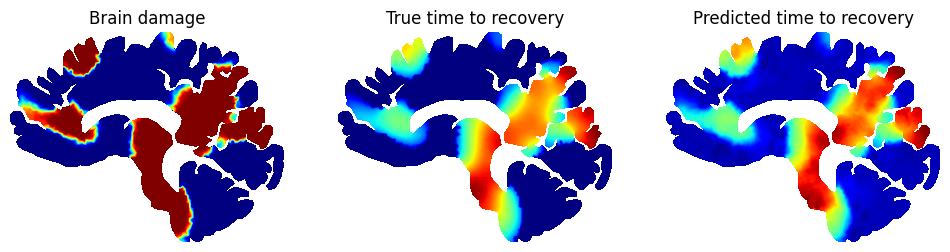

In [ ]:
# Print a random test snapshot against the corresponding prediction

which = 10
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_test[which], Vh_ref, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_test[which], Vh_ref, cmap='jet_r')
plt.subplot(1, 3, 2)
plt.title("True time to recovery")
fe.plot(u_test[which], Vh_ref, cmap='jet')
plt.subplot(1, 3, 3)
plt.title("Predicted time to recovery")
fe.plot(u_pred[which], Vh_ref, cmap='jet')

# Multi-fidelity model - H2C

In [14]:
# DLROM definition

layer_1 = Geodesic(domain, Vh_ref, Vh_C, support=0.05) # default activation: leakyReLU
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_ref, support=0.05, activation=None)

In [15]:
# Train the first two layers with low-fidelity snapshots (with random initialization)

model = DFNN(layer_1, layer_2)
model.He()

if device.type == "cuda":
  model.cuda()
else:
  model.cpu()

# model.train(mu_train, u_train, ntrain=N_train, epochs=100, loss=mse(euclidean), verbose=True)
model.train(mu_train, u_train, ntrain=int(0.9*N_train), epochs=3000, optim=torch.optim.Adam, lr=0.01, loss=mse(euclidean), batchsize=int(0.1*N_train), verbose=True)

		Train		Test
Epoch 505:	1.47e+01	3.11e+01.

>> ETA: 1m 43.27s.


KeyboardInterrupt: 

In [ ]:
### mesh30 ###
# Overfitting after 10 epochs ca., both train and validation are still high (o.d.g. 2e+01)
### mesh25 ###
# Overfitting after 10 epochs ca., both train and validation are still high (o.d.g. 2e+01)

In [ ]:
# Train the DLROM with high-fidelity snapshots (with random initialization)

model.freeze()

model_ref = DFNN(model, layer_3)
model_ref.He()

if device.type == "cuda":
  model_ref.cuda()
else:
  model_ref.cpu()

model_ref.train(mu_train_ref, u_train_ref, ntrain=N_train_ref, epochs=100, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 100:	2.81e-01	nan.

>> ETA: 0.45s.

Training complete. Elapsed time: 45.25 seconds.


In [ ]:
# Use the model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model_ref(mu_train_ref)
  u_pred = model_ref(mu_test)

error_train = torch.norm(u_train_ref - u_pred_train, dim=1) / torch.norm(u_train_ref, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 5.64%
Relative test error: 40.84%


In [ ]:
### mesh30 ###
# 900 + 90 snapshots, 100 + 100 epochs: train 6.24%, test 40.14%
# 900 + 180 snapshots, 100 + 100 epochs: train 7.80%, test 24.26%
# 900 + 360 snapshots, 100 + 100 epochs: train 8.51%, test 17.98%

# Multi-fidelity model \#2

In [ ]:
# DLROM definition

layer_1 = Geodesic(domain, Vh_ref, Vh_C, support=0.05) # default activation: leakyReLU
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_4 = Geodesic(domain, Vh_C, Vh_ref, support=0.05, activation=None)

In [ ]:
# Train the two middle layers with low-fidelity snapshots (with random initialization)

model = DFNN(layer_2, layer_3)
model.He()

if device.type == "cuda":
  model.cuda()
else:
  model.cpu()

model.train(mu_train, u_train, ntrain=N_train, epochs=300, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 300:	9.25e-02	nan.

>> ETA: 0.33s.

Training complete. Elapsed time: 1 minutes 39.67 seconds.


In [ ]:
# Low-fidelity, 900 snapshots, 300 epochs: loss 0.25e-02

In [ ]:
# Train the DLROM with high-fidelity snapshots (with random initialization)

model.freeze() # freeze the middle layer

model_ref = DFNN(layer_1, model, layer_4)
model_ref.He()

if device.type == "cuda":
  model_ref.cuda()
else:
  model_ref.cpu()

model_ref.train(mu_train_ref, u_train_ref, ntrain=N_train_ref, epochs=300, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 300:	4.23e-01	nan.

>> ETA: 0.40s.

Training complete. Elapsed time: 1 minutes 59.14 seconds.


In [ ]:
# Use the model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model_ref(mu_train_ref)
  u_pred = model_ref(mu_test)

error_train = torch.norm(u_train_ref - u_pred_train, dim=1) / torch.norm(u_train_ref, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 7.10%
Relative test error: 14.15%


In [ ]:
# Multi-fidelity, 900 + 450 snapshots, 300 + 300 epochs: loss 4.23, train 7.10%, test 14.15%

# Multi-fidelity model \#3

In [ ]:
# DLROM definition

layer_1 = DFNN(Geodesic(domain, Vh_ref, Vh_C, support=0.05)) # default activation: leakyReLU
layer_2 = DFNN(Geodesic(domain, Vh_C, Vh_C, support=0.1))
layer_3 = DFNN(Geodesic(domain, Vh_C, Vh_ref, support=0.05, activation=None))

In [ ]:
# Train the DLROM with high-fidelity snapshots (with random initialization)

model = DFNN(layer_1, layer_2, layer_3)
model.He()

if device.type == "cuda":
  model.cuda()
else:
  model.cpu()

model.train(mu_train_ref, u_train_ref, ntrain=N_train_ref, epochs=100, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 100:	3.71e-01	nan.

>> ETA: 0.32s.

Training complete. Elapsed time: 31.77 seconds.


In [ ]:
# Use the initial model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model(mu_train_ref)
  u_pred = model(mu_test)

error_train = torch.norm(u_train_ref - u_pred_train, dim=1) / torch.norm(u_train_ref, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 6.37%
Relative test error: 37.66%


In [ ]:
# Further train the middle layer with low-fidelity snapshots

layer_1.freeze()
layer_3.freeze()

layer_2.train(mu_train, u_train, ntrain=N_train, epochs=100, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 100:	6.25e-01	nan.

>> ETA: 0.29s.

Training complete. Elapsed time: 28.90 seconds.


In [ ]:
# Use the final model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model(mu_train_ref)
  u_pred = model(mu_test)

error_train = torch.norm(u_train_ref - u_pred_train, dim=1) / torch.norm(u_train_ref, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 777.57%
Relative test error: 780.39%


# Multi-fidelity model \#4

In [ ]:
# Define very coarse space

mesh_pre = fe.loadmesh("./brain-meshes/brain-mesh1.xml")
h_pre = mesh_pre.hmax()
Vh_pre = fe.space(mesh_pre, 'CG', 1)
nh_pre = Vh_pre.dim()
print(nh_pre)

807


In [ ]:
# Load very low-fidelity snapshots for training

data_train_pre = np.load("snapshots_train_CC.npz")
N_train_pre = data_train_pre['mu'].shape[0]
mu_train_pre, u_train_pre = data_train_pre['mu'].astype(np.float32), data_train_pre['u'].astype(np.float32)
# mu_train_pre, u_train_pre = torch.tensor(mu_train_pre).to(device), torch.tensor(u_train_pre).to(device)

In [ ]:
# Interpolation

# from fenics import Function
# from fenics import interpolate

# u_train_pre_fun = Function(Vh_pre)

# u_train_pre_C = np.zeros((u_train_pre.shape[0], Vh_C.dim()))
# print(u_train_pre_C.shape)

# for i in range(u_train_pre.shape[0]):
#   u_train_pre_fun.vector()[:] = u_train_pre[i, :]
#   u_train_pre_C_fun = interpolate(u_train_pre_fun, Vh_C)
#   u_train_pre_C[i, :] = u_train_pre_C_fun.vector().get_local()

# mu_train_pre, u_train_pre_C = torch.tensor(mu_train_pre).to(device), torch.tensor(u_train_pre_C).to(device)
# print(mu_train_pre.shape)
# print(u_train_pre_C.shape)

In [ ]:
# Deterministic initialization

def Det(chi, V_coarse, V_fine, r):

  M = 0

  coords_coarse = V_coarse.tabulate_dof_coordinates() # (Mh + 1) pairs
  coords_fine = V_fine.tabulate_dof_coordinates() # (Nh + 1) pairs

  dim = len(coords_coarse[0]) # x, y
  for j in range(dim):
    dj = coords_coarse[:, j].reshape(-1, 1) - coords_fine[:, j].reshape(1, -1) # shape (Mh + 1) ** 2 x (Nh + 1) ** 2
    M = M + dj**2

  M = np.sqrt(M)
  M = M * (M < r) - (M >= r) # set the distances for the points outside the support to -1

  nonzeros = len(chi.loc[0]) # number of active weights
  weights = np.zeros((chi.in_d, chi.out_d), dtype='float32')

  for i in range(nonzeros):
    weights[chi.loc[0][i], chi.loc[1][i]] = np.exp(-M[chi.loc[0][i], chi.loc[1][i]]) # w = exp{-d}

  for i in range(chi.out_d):
    weights[:, i] = weights[:, i] / np.sum(weights[:, i]) # weights normalization

  weights = weights.reshape(-1)
  weights = weights[np.where(weights != 0)] # keep only nonzero weights

  return weights